In [1]:
# this file calculates raster statistics of a specified polygon. 

In [1]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import rasterstats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from os import path

ImportError: DLL load failed while importing _network: The specified module could not be found.

In [3]:
# identify working directories for exports
current_dir = os.getcwd() # current directory for scripts/git
parent_dir = os.path.dirname(current_dir) # one level up for exports
parent_dir = os.path.dirname(parent_dir)

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 591,
 'height': 663,
 'count': 234,
 'crs': CRS.from_epsg(32719),
 'transform': Affine(29.99981, 0.0, 766641.15,
        0.0, -30.0, 6997860.133)}

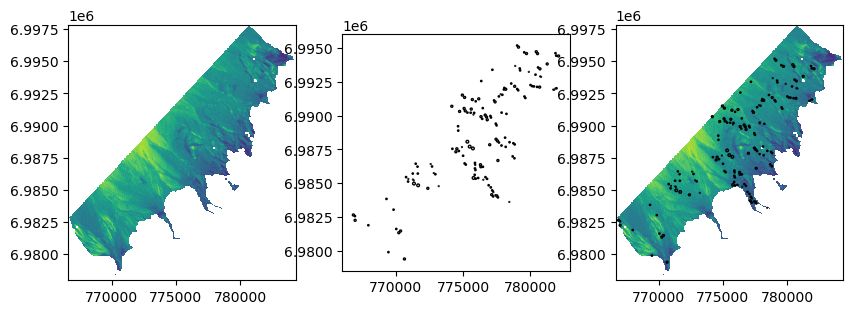

In [24]:
## READ IN DATA 

#locate files
image_file = r'C:\Users\htccr\Documents\Aconquija\imagery\prisma\PRS_L2D_STD_20210815143130_20210815143134_0001\exports\clipped\PRIMSA_20210815_stack_ortho_clip-surfaces_BCET.tif'
polygons_file = r'C:\Users\htccr\Documents\Aconquija\GIS_data\SPOTS_1_python.shp'

# read in files
image = rasterio.open(image_file, mode = 'r')
polygons = gpd.read_file(polygons_file)

# plot as check
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
show(image, ax = ax1)

polygons.plot(ax = ax2, facecolor = 'none', edgecolor = 'black')

show(image, ax = ax3)
polygons.plot(ax = ax3, facecolor = 'none', edgecolor = 'black')

# image metadata
image.meta

In [25]:
## Calculate raster statistics of each polygon i.e. fan, for each band 
# see for zonal_stats function info: https://pythonhosted.org/rasterstats/manual.html#zonal-statistics

meta = image.meta # variable for accessing meta data
affine = image.transform # record affine for stats below

# choose statistics to calculate
stats = ['mean', 'std'] # see default options from zonal_stats

# create empty array to fill with polygon attributes and new raster stats data from each fan, for each band
pix_stat_array = np.empty((meta['count'], len(polygons)), dtype = dict) # dtype only works as dict, list, or object (?)

# calculate zonal statistics    
for i in range(meta['count']): # for i in range of bands
    ii = i + 1
    image_array = image.read(ii) # read image at that band
    
    # calcuate new statistics and fill empty array with existing attributes and these.  
    pix_stat_array[i] = rasterstats.zonal_stats(polygons, image_array, affine = affine, # image array is unique!
                                                stats = stats, # new stats 
                                                nodata = 0.0,
                                                geojson_out = True, # keep existing polygon attributes
                                                all_touched = False) # include edge pix? False means no

In [26]:
# check for new statistics!
pix_stat_array[0][0]['properties'] #array[band][unique fan]['properties i.e. attributes]

{'FIRST_Unit': 'Q3',
 'FIRST_fan': 'Co',
 'FIRST_uniq': '130CoQ3',
 'Id': 0,
 'Join_Count': 1,
 'MEAN_abs_a': 107.699996948,
 'MEAN_age_n': 1.0,
 'MEAN_age_s': 22.1000003815,
 'SUM_area': 2676195.0,
 'TARGET_FID': 0,
 'unique': '130CoQ3',
 'mean': 21119.666666666668,
 'std': 3392.6727909815686}

In [31]:
# extract statistics from array, and create dataframe 
# 1. extract existing properties stores in the polygons e.g. age, unique id, etc.
# 2. create base dataframe, drop first set of new stats 
# 3. Loop through all unique fan surfaces i.e. polygons, by band and extract new statistics into lists
# 4. Append new stats list to the dataframe

properties_list = [] # create empty list to store 
for jj in range(len(polygons)): # for each fan...
    properties_list.append(pix_stat_array[0][jj]['properties']) # extract all properties i.e. existing attributes & new stats. 
    # ^ append to empty list

df = pd.DataFrame(properties_list) # create dataframe from list
df = df.drop(columns=stats) # drop the first 


for ii in range(meta['count']):
    mean_pix_list = []
    std_pix_list = []
    for jj in range(len(polygons)):
        mean_pix_list.append(pix_stat_array[ii][jj]['properties']['mean'])
        std_pix_list.append(pix_stat_array[ii][jj]['properties']['std'])
    
    df['B{}_mean'.format(ii + 1)] = mean_pix_list
    df['B{}_std'.format(ii + 1)] = std_pix_list
        
df.head()

C:\Users\htccr\AppData\Local\Temp/ipykernel_70860/3549686836.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['B{}_std'.format(ii + 1)] = std_pix_list
C:\Users\htccr\AppData\Local\Temp/ipykernel_70860/3549686836.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['B{}_mean'.format(ii + 1)] = mean_pix_list


,FIRST_Unit,FIRST_fan,FIRST_uniq,Id,Join_Count,MEAN_abs_a,MEAN_age_n,MEAN_age_s,SUM_area,TARGET_FID,...,B230_mean,B230_std,B231_mean,B231_std,B232_mean,B232_std,B233_mean,B233_std,B234_mean,B234_std
0,Q3,Co,130CoQ3,0,1,107.699997,1.0,22.1,2676195.0,0,...,28666.888889,1412.731982,29106.444444,3080.559585,34530.333333,5717.624895,33978.000000,4682.886384,23489.000000,1771.611507
1,Q3,Co,130CoQ3,0,1,107.699997,1.0,22.1,2676195.0,1,...,32616.263158,1854.321179,32089.157895,2368.452465,38661.210526,3941.601152,33326.052632,5186.649456,15469.736842,2457.694873
2,Q3,Co,130CoQ3,0,1,107.699997,1.0,22.1,2676195.0,2,...,31905.950000,1533.320269,30460.300000,2681.559529,35415.300000,4315.507793,30163.850000,5347.677386,15905.350000,2553.803620
3,Q3,Co,130CoQ3,0,1,107.699997,1.0,22.1,2676195.0,3,...,31857.111111,2652.630411,33467.333333,2564.264634,37945.000000,3547.938400,32823.111111,5615.107982,17565.333333,1411.258146
4,Q3,Co,130CoQ3,0,1,107.699997,1.0,22.1,2676195.0,4,...,32949.625000,1501.710353,32439.500000,3168.371388,36138.375000,3119.029213,27625.625000,5044.378702,15155.125000,2451.782843


In [8]:
# Create 'clean' dataframe without modern (i.e. age = 0), or rock avalanch "Av" units. 
clean = df.drop(df[df.Unit == "Modern"].index)
clean = clean.drop(clean[clean.Unit == "Av"].index)


AttributeError: 'DataFrame' object has no attribute 'Unit'

In [ ]:
# Plot spectral signature as bands

#bands_only = df.drop(columns=['Unit', 'unique','age_n','age_sd','area','fan']) # drop specified columns
bands_only = df.drop(columns=['FIRST_Unit', 'FIRST_fan','FIRST_uniq','Id', 'Join_Count', 'MEAN_age_n', 'MEAN_age_s', 'SUM_area','TARGET_FID', 'unique']) # drop specified columns
#bands_only = df.drop(columns=['MEAN_abs_a', 'FIRST_fan','FIRST_uniq','Id', 'Join_Count', 'MEAN_age_n', 'MEAN_age_s', 'SUM_area','TARGET_FID', 'unique'])

bands_only = bands_only.drop(columns = ['B{}_std'.format(i) for i in range(1, meta['count'] + 1)])

In [32]:
# Group rows of same UNIT and take mean
# I will likley have to rewrite this code to sample every SPOT seperatly, then group all the SPOTS together based on the uniqueID. This way we can carry standard deviations though. 

bands_only = df.drop(columns=['MEAN_abs_a', 'FIRST_fan','FIRST_uniq','Id', 'Join_Count', 'MEAN_age_n', 'MEAN_age_s', 'SUM_area','TARGET_FID', 'unique'])
bands_only = bands_only.drop(columns = ['B{}_std'.format(i) for i in range(1, meta['count'] + 1)])
bands_only['FIRST_Unit'] = bands_only['FIRST_Unit'].replace(['Modern'],'Q8 (modern)')

bands_unit = bands_only.groupby(['FIRST_Unit'], dropna = True).mean() # group rows, take mean of variables, and also sorts by group value 

# extract ages index for plotting
band_names = np.array(bands_unit.columns.values)
unit_names = np.array(bands_unit.index.values)

In [10]:
# Group rows of same age (e.g. 0.0) and take mean
# I will likley have to rewrite this code to sample every SPOT seperatly, then group all the SPOTS together based on the uniqueID. This way we can carry standard deviations though. 
#bands = bands_only.groupby(['abs_age'], dropna = False).mean() # group rows, take mean of variables, and also sorts by group value 

bands_only = df.drop(columns=['FIRST_Unit', 'FIRST_fan','FIRST_uniq','Id', 'Join_Count', 'MEAN_age_n', 'MEAN_age_s', 'SUM_area','TARGET_FID', 'unique']) # drop specified columns
bands_only = bands_only.drop(columns = ['B{}_std'.format(i) for i in range(1, meta['count'] + 1)])

bands_age = bands_only.groupby(['MEAN_abs_a'], dropna = False).mean() # group rows, take mean of variables, and also sorts by group value 

# extract ages index for plotting
band_names = np.array(bands_age.columns.values)
ages = np.array(bands_age.index.values.astype(float))
ages = np.round(ages, 2)

In [33]:
# normalize data
norm_across_band = (bands_unit.T - bands_unit.T.mean())/bands_unit.T.std()

norm_same_band = (bands_unit - bands_unit.mean())/bands_unit.std() # normalize data for each individual bands i.e. each band has a mean spectral reflectance mean(B1) across observations
norm_same_band_across = (norm_same_band.T - norm_same_band.T.mean())/norm_same_band.T.std() # normalized the normalized individual bands, across all bands i.e. across the spectrum

#scaled01 = (norm_same_band_across - norm_same_band_across.min())/(norm_same_band_across.max() - norm_same_band_across.min()) # scale to 0 to 1 range, seems incorrect

In [16]:
# normalize data
norm_across_band = (bands_age.T - bands_age.T.mean())/bands_age.T.std()

norm_same_band = (bands_age - bands_age.mean())/bands_age.std() # normalize data for each individual bands i.e. each band has a mean spectral reflectance mean(B1) across observations
norm_same_band_across = (norm_same_band.T - norm_same_band.T.mean())/norm_same_band.T.std() # normalized the normalized individual bands, across all bands i.e. across the spectrum

#scaled01 = (norm_same_band_across - norm_same_band_across.min())/(norm_same_band_across.max() - norm_same_band_across.min()) # scale to 0 to 1 range, seems incorrect

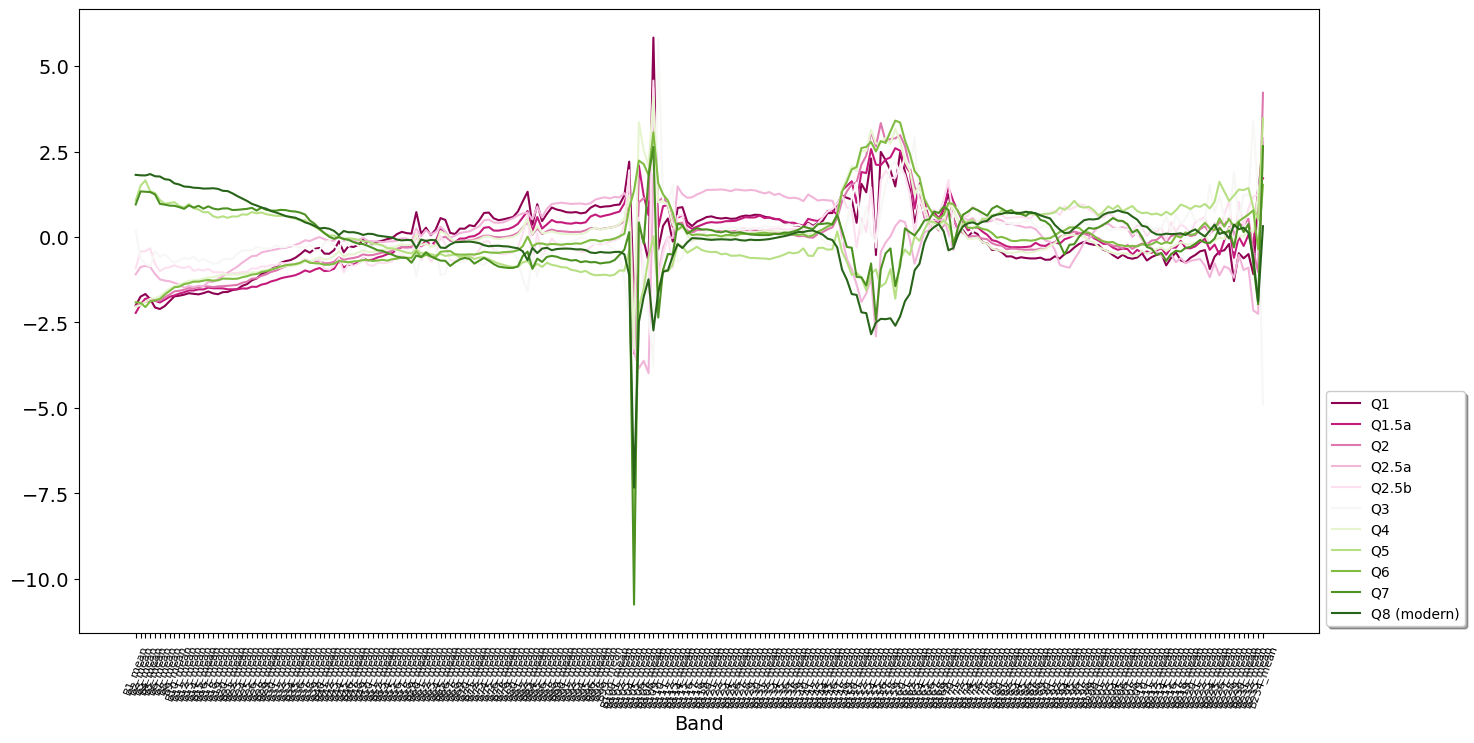

In [38]:
target = norm_across_band.T
target_names = unit_names

N = len(target) # number of objects to plot i.e. color cycle count

plt.rcParams["figure.figsize"] = [16,9] # fig size
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.PiYG(np.linspace(0,1,N))) # colors to cycle through, choose default like 'viridis' or 'PiYG'

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(target.iloc[i], label = target_names[i]) # for i in range of objects, plot x,y

#plt.legend(loc = 'right')
plt.xlabel('Band', fontsize = 14)
plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.yticks(fontsize = 14)

# cutum legend location
# get legend location
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          fancybox=True, shadow=True, ncol=1)

plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()

In [ ]:
normed = norm_across_band

#scaled01 = (bands - bands.min())/(bands.max() - bands.min()) # scale to 0 to 1 range, seems incorrect

N = len(target) # number of objects to plot i.e. color cycle count

plt.rcParams["figure.figsize"] = [16,9] # fig size
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.PiYG(np.linspace(0,1,N))) # colors to cycle through, choose default like 'viridis' or 'PiYG'

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(normed.T.iloc[i], label = target_names[i]) # for i in range of objects, plot x,y
    
plt.xlim(90,200)

#plt.legend(loc = 'right')
plt.xlabel('Band', fontsize = 14)
plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.yticks(fontsize = 14)

# cutum legend location
# get legend location
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          fancybox=True, shadow=True, ncol=1)

plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()

In [ ]:
ratio = (normed.iloc[104] + abs(test.T.iloc[20]))

plt.figure()
plt.scatter(unit_names, ratio)

In [ ]:
test = norm_across_band.T

ratio = abs(test.T.iloc[20])


plt.figure()
plt.scatter(unit_names, ratio,  c = 'red')


In [ ]:
bands.T.iloc[0]

In [ ]:


plt.figure()
plt.scatter(unit_names, normed.iloc[20])
plt.xlabel('Age')
plt.ylabel('Rel. Reflectance')
plt.title('B42/2 (VIS)')
plt.xlim()


In [40]:
# Export final dataframe
export = norm_same_band_across # choose df to export

export.to_csv(parent_dir + '\outputs\\SPOTS_units_norm_all_BCET.csv', header = True) # '\selected_folder\\filename.file-type'

In [ ]:
# spot sample and clean up variance
# remove mean and create anomalies
# Use PCs
# extract ages as an array and do plt.plot(PCs[:,kk], ages)

# reconstruct the new data using the first few PCs of model-built data, nit neccisarily the index. 

In [ ]:
# KEEP FOR EXAMPLE/ SAFE KEEPING

In [ ]:
N = 28 # number of objects to plot i.e. color cycle count

plt.rcParams["figure.figsize"] = [16,9] # fig size
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.PiYG(np.linspace(0,1,N))) # colors to cycle through, choose default like 'viridis' or 'PiYG'

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(data[i], label = data.index.values.astype(float)[i]) # for i in range of objects, plot x,y

#plt.legend(loc = 'right')
plt.xlabel('Band', fontsize = 14)
plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.yticks(fontsize = 14)

# cutum legend location
# get legend location
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          fancybox=True, shadow=True, ncol=1)

plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()

In [ ]:
# re-run itrative list but just collecting band information

age_list = [] # create empty list to store 
for jj in range(len(polygons)): # for each fan...
    age_list.append(pix_stat_array[0][jj]['properties']['abs_age']) # extract all properties i.e. existing attributes & new stats. 
    # ^ append to empty list

bands_only = pd.DataFrame({'age': age_list}) # create dataframe from list


for ii in range(meta['count']):
    mean_pix_list = []
    #std_pix_list = []
    for jj in range(len(polygons)):
        mean_pix_list.append(pix_stat_array[ii][jj]['properties']['mean'])
        #std_pix_list.append(pix_stat_array[ii][jj]['properties']['std'])
    
    bands_only['B{}_mean'.format(ii + 1)] = mean_pix_list
    #df2['B{}_std'.format(ii + 1)] = std_pix_list
        
bands_only = bands_only.sort_values('age', axis=0, ascending=True) # sort dataframe by age
bands_only['age'] = round(bands_only['age'], 2) # round ages to 2 sig figs
